In [1]:
%reload_ext autoreload
%autoreload 2
import os
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import cartopy
import plots
import pathlib
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator, FuncFormatter
from matplotlib.lines import Line2D
from shapely.geometry import box
from utils import createDuckCon, loadTrackingTable, loadSpatialTracking
from dask.distributed import Client, LocalCluster, progress
from dask.diagnostics import ProgressBar

ProgressBar().register()

In [ ]:
# Config dataset names
gsmap_name = "GSMaP-MKV v8"
imerg_name = "IMERG Final V07"

# Set path for the tracking table files
gsmap_trackingtable = '/prj/cptec/helvecio.leal/tracks/gsmap/track/grouped/*.parquet'
imerg_trackingtable = '/prj/cptec/helvecio.leal/tracks/imerg/track/grouped/*.parquet'

# Set paths for the netcdfs files
gsmap_netcdf_path = '/prj/cptec/helvecio.leal/tracks/gsmap/spatial/'
imerg_netcdf_path = '/prj/cptec/helvecio.leal/tracks/imerg/spatial/'

In [ ]:
# Create DuckDB connection
con = createDuckCon("/prj/cptec/helvecio.leal/tmp/propertiesps.duckdb")


# Create Dask client
for v in ["OMP_NUM_THREADS","MKL_NUM_THREADS","OPENBLAS_NUM_THREADS",
          "BLIS_NUM_THREADS","NUMEXPR_NUM_THREADS","NUMBA_NUM_THREADS"]:
    os.environ.setdefault(v, "1")

n_cores = mp.cpu_count() - 1
cluster = LocalCluster(processes=True, n_workers=n_cores, threads_per_worker=1, memory_limit="auto")
client = Client(cluster)
print(client)

def compute(ds):
    ds_persisted = ds.persist()
    futures = client.compute(ds_persisted)
    progress(futures, notebook=False)
    return client.gather(futures)

<Client: 'tcp://127.0.0.1:37477' processes=95 threads=95, memory=373.16 GiB>


In [6]:
# Load tracking tables into DuckDB
loadTrackingTable(con, gsmap_trackingtable, 'gsmap_tracking')
loadTrackingTable(con, imerg_trackingtable, 'imerg_tracking')

In [6]:
# Load spatial tracking data
gsmap_ds_v8 = loadSpatialTracking(gsmap_netcdf_path)
imerg_ds_v7 = loadSpatialTracking(imerg_netcdf_path)

Loading spatial tracking data from: /mnt/data/tracks/gsmap_v8_2015-2024/01mmhr_v8/spatial/
Loading spatial tracking data from: /mnt/data/tracks/imerg_final_v7_2015-2024/01mmhr_v7/spatial/


#### Figure 5.9 - Global seasonal mean accumulated precipitation of tracked PSs for GSMaP (left) and IMERG (right) over the 2015–2024 period

In [ ]:
# Get precipitation values
gsmap_precip = gsmap_ds_v8['clu-values']
imerg_precip = imerg_ds_v7['clu-values'] * 0.5 # Adjust IMERG to 30-min resolution

def seasonal_accum_mean(ds, season):
    ds_season = ds.sel(time=ds['time.season'] == season)
    mean_acum = ds_season.mean(dim='time', skipna=True)
    return mean_acum

gsmap_precip_jja = seasonal_accum_mean(gsmap_precip, 'JJA').compute()
gsmap_precip_son = seasonal_accum_mean(gsmap_precip, 'SON').compute()
gsmap_precip_djf = seasonal_accum_mean(gsmap_precip, 'DJF').compute()
gsmap_precip_mam = seasonal_accum_mean(gsmap_precip, 'MAM').compute()
imerg_precip_jja = seasonal_accum_mean(imerg_precip, 'JJA').compute()
imerg_precip_son = seasonal_accum_mean(imerg_precip, 'SON').compute()
imerg_precip_djf = seasonal_accum_mean(imerg_precip, 'DJF').compute()
imerg_precip_mam = seasonal_accum_mean(imerg_precip, 'MAM').compute()

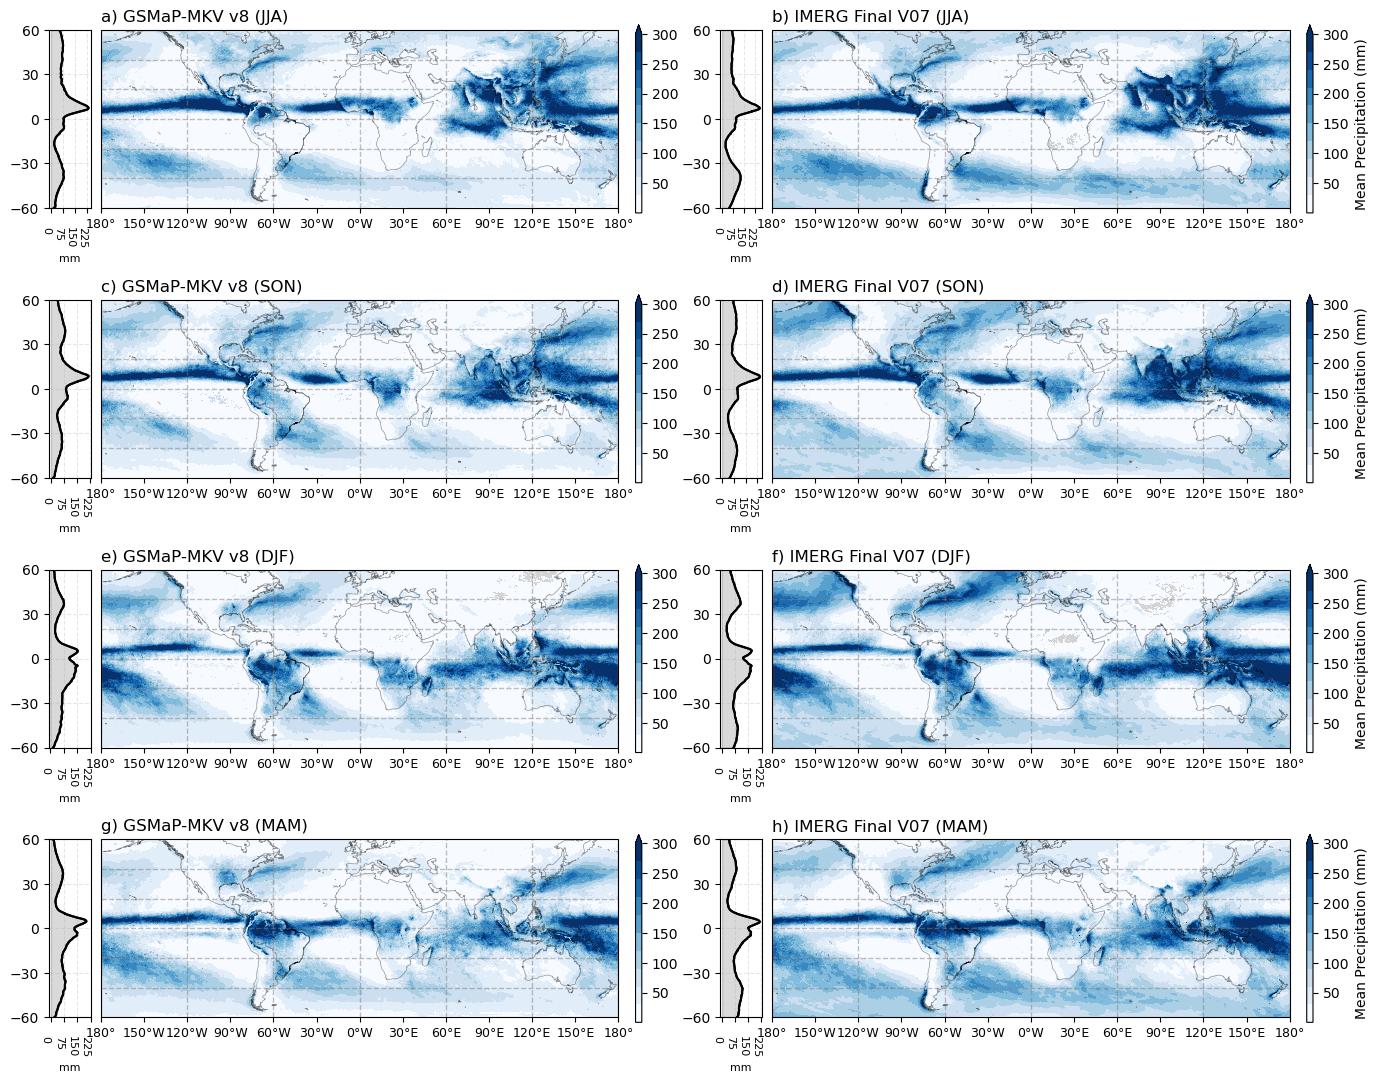

In [13]:
# Figure that shows seasonal mean precipitation
fig, axes = plt.subplots(4, 2, figsize=(16, 14), dpi=100, subplot_kw={'projection': cartopy.crs.PlateCarree()}, gridspec_kw={'hspace': 0.0045, 'wspace': 0.18})
plots.map(gsmap_precip_jja, figsize=(12, 12), ax=axes[0,0], title='', ylim=[-60, 60], cmap_num=10, cmap='Blues', max_val=300,  cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7,
            lat_density=True, lat_mean=True, lat_mean_ticks=np.arange(0, 230, 75), lat_xlabel='mm')
plots.map(imerg_precip_jja, figsize=(12, 12), ax=axes[0,1], title='', ylim=[-60, 60], cmap_num=10, cmap='Blues', max_val=300, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='Mean Precipitation (mm)',
          lat_density=True, lat_mean=True, lat_mean_ticks=np.arange(0, 230, 75), lat_xlabel='mm')
plots.map(gsmap_precip_son, figsize=(12, 12), ax=axes[1,0], title='', ylim=[-60, 60], cmap_num=10, cmap='Blues', max_val=300, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, 
            lat_density=True, lat_mean=True, lat_mean_ticks=np.arange(0, 230, 75), lat_xlabel='mm')
plots.map(imerg_precip_son, figsize=(12, 12), ax=axes[1,1], title='', ylim=[-60, 60], cmap_num=10, cmap='Blues', max_val=300, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='Mean Precipitation (mm)',
            lat_density=True, lat_mean=True, lat_mean_ticks=np.arange(0, 230, 75), lat_xlabel='mm')
plots.map(gsmap_precip_djf, figsize=(12, 12), ax=axes[2,0], title='', ylim=[-60, 60], cmap_num=10, cmap='Blues', max_val=300, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, 
            lat_density=True, lat_mean=True, lat_mean_ticks=np.arange(0, 230, 75), lat_xlabel='mm')
plots.map(imerg_precip_djf, figsize=(12, 12), ax=axes[2,1], title='', ylim=[-60, 60], cmap_num=10, cmap='Blues', max_val=300, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='Mean Precipitation (mm)',
            lat_density=True, lat_mean=True, lat_mean_ticks=np.arange(0, 230, 75), lat_xlabel='mm')
plots.map(gsmap_precip_mam, figsize=(12, 12), ax=axes[3,0], title='', ylim=[-60, 60], cmap_num=10, cmap='Blues', max_val=300, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, 
            lat_density=True, lat_mean=True, lat_mean_ticks=np.arange(0, 230, 75), lat_xlabel='mm')
plots.map(imerg_precip_mam, figsize=(12, 12), ax=axes[3,1], title='', ylim=[-60, 60], cmap_num=10, cmap='Blues', max_val=300, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='Mean Precipitation (mm)',
            lat_density=True, lat_mean=True, lat_mean_ticks=np.arange(0, 230, 75), lat_xlabel='mm')
axes[0,0].set_title(f"a) {gsmap_name} (JJA)", loc='left', y=1)
axes[0,1].set_title(f"b) {imerg_name} (JJA)", loc='left', y=1)
axes[1,0].set_title(f"c) {gsmap_name} (SON)", loc='left', y=1)
axes[1,1].set_title(f"d) {imerg_name} (SON)", loc='left', y=1)
axes[2,0].set_title(f"e) {gsmap_name} (DJF)", loc='left', y=1)
axes[2,1].set_title(f"f) {imerg_name} (DJF)", loc='left', y=1)
axes[3,0].set_title(f"g) {gsmap_name} (MAM)", loc='left', y=1)
axes[3,1].set_title(f"h) {imerg_name} (MAM)", loc='left', y=1);

##### Figure 5.10 - Boxplots of monthly mean precipitation within the footprints of tracked PSs, stratified by Land (a), Ocean (b), Tropics (c), and Extratropics (d) for GSMaP and IMERG over the 2015–2024 period

In [6]:
# Create GeoDataFrame for Tropical and Extratropical regions
tropics_geom = box(-180, -23.5, 180, 23.5)
extratropics_geom = box(-180, -90, 180, -23.5).union(box(-180, 23.5, 180, 90))
tropics_gdf = gpd.GeoDataFrame({'region': ['Tropics'], 'geometry': [tropics_geom]}, crs='EPSG:4326')
extratropic_gdf = gpd.GeoDataFrame({'region': ['Extratropics'], 'geometry': [extratropics_geom]}, crs='EPSG:4326')

# Create ocean and land masks using cartopy
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m')
ocean_50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m')
land_geom = gpd.GeoDataFrame(geometry=list(land_50m.geometries()), crs='EPSG:4326')
ocean_geom = gpd.GeoDataFrame(geometry=list(ocean_50m.geometries()), crs='EPSG:4326')

In [13]:
def monthly_accum_mean(ds, month):
    ds_month = ds.sel(time=ds['time.month'] == month)
    mean_acum = ds_month.mean(dim='time', skipna=True)
    return mean_acum
# Separate monthly data for tropics and extratropics
months = list(range(1, 13))  # 1-12 for Jan-Dec
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Dictionary to store all monthly data
monthly_data = {
    'Tropics': {'gsmap': [], 'imerg': []},
    'Extratropics': {'gsmap': [], 'imerg': []},
    'Ocean': {'gsmap': [], 'imerg': []},
    'Land': {'gsmap': [], 'imerg': []}
}
# Process data for each month
for month in months:
    # Tropics
    gsmap_tropics_month = monthly_accum_mean(gsmap_precip.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(tropics_gdf.geometry, tropics_gdf.crs), month).compute()
    imerg_tropics_month = monthly_accum_mean(imerg_precip.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(tropics_gdf.geometry, tropics_gdf.crs), month).compute()
    # Extratropics
    gsmap_extratropics_month = monthly_accum_mean(gsmap_precip.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(extratropic_gdf.geometry, extratropic_gdf.crs), month).compute()
    imerg_extratropics_month = monthly_accum_mean(imerg_precip.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(extratropic_gdf.geometry, extratropic_gdf.crs), month).compute()
    # Ocean
    gsmap_ocean_month = monthly_accum_mean(gsmap_precip.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(ocean_geom.geometry, ocean_geom.crs), month).compute()
    imerg_ocean_month = monthly_accum_mean(imerg_precip.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(ocean_geom.geometry, ocean_geom.crs), month).compute()
    # Land
    gsmap_land_month = monthly_accum_mean(gsmap_precip.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(land_geom.geometry, land_geom.crs), month).compute()
    imerg_land_month = monthly_accum_mean(imerg_precip.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(land_geom.geometry, land_geom.crs), month).compute()
    # Store in dictionary
    monthly_data['Tropics']['gsmap'].append(gsmap_tropics_month)
    monthly_data['Tropics']['imerg'].append(imerg_tropics_month)
    monthly_data['Extratropics']['gsmap'].append(gsmap_extratropics_month)
    monthly_data['Extratropics']['imerg'].append(imerg_extratropics_month)
    monthly_data['Ocean']['gsmap'].append(gsmap_ocean_month)
    monthly_data['Ocean']['imerg'].append(imerg_ocean_month)
    monthly_data['Land']['gsmap'].append(gsmap_land_month)
    monthly_data['Land']['imerg'].append(imerg_land_month)
# Prepare data in long format using monthly data
data_list = []
regions = ['Land', 'Ocean', 'Tropics', 'Extratropics']
products = ['gsmap', 'imerg']
for region in regions:
    for i, month_name in enumerate(month_names):
        for product in products:
            values = monthly_data[region][product][i].values.flatten()
            values = values[~np.isnan(values)]
            
            n = len(values)
            data_list.append(pd.DataFrame({
                'Precipitation': values,
                'Product': gsmap_name if product=='gsmap' else imerg_name,
                'Region': region,
                'Month': month_name
            }))
precip_df = pd.concat(data_list, ignore_index=True)

[########################################] | 100% Completed | 1.09 sms
[########################################] | 100% Completed | 1.18 s
[########################################] | 100% Completed | 1.28 s
[########################################] | 100% Completed | 613.27 ms
[########################################] | 100% Completed | 614.19 ms
[########################################] | 100% Completed | 617.11 ms
[########################################] | 100% Completed | 614.70 ms
[########################################] | 100% Completed | 716.02 ms
[########################################] | 100% Completed | 816.89 ms
[########################################] | 100% Completed | 715.58 ms
[########################################] | 100% Completed | 816.42 ms
[########################################] | 100% Completed | 913.88 ms
[########################################] | 100% Completed | 611.17 ms
[########################################] | 100% Completed | 710.11 ms

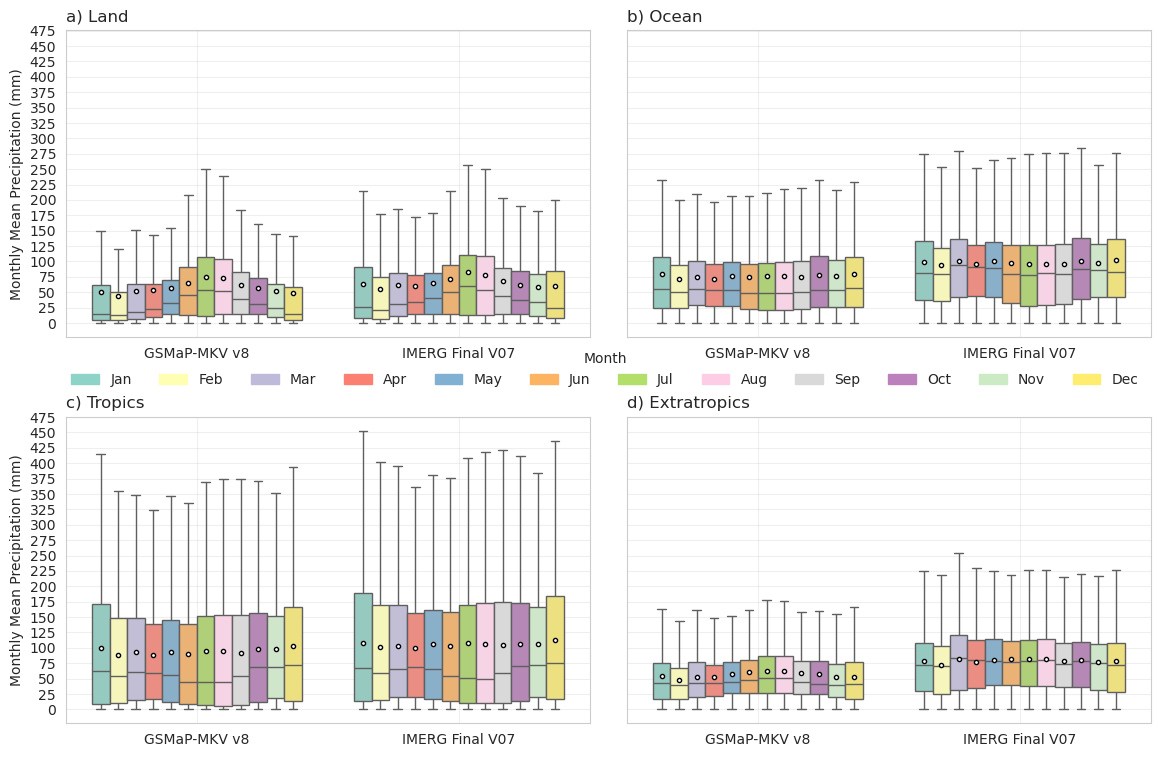

In [14]:
# This to slow to plot
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharey=True, gridspec_kw={'hspace': 0.26, 'wspace': 0.07})
sns.set_style("whitegrid")
colors = plt.cm.Set3(np.linspace(0, 1, 12))
patches = [mpatches.Patch(color=colors[i], label=month_names[i]) for i in range(12)]
for i, (ax, region) in enumerate(zip(axes.flatten(), regions)):
    region_df = precip_df.loc[precip_df['Region'] == region]
    sns.boxplot(
        data=region_df,
        x='Product',
        y='Precipitation',
        hue='Month',
        palette=colors,
        ax=ax,
        showfliers=False,
        hue_order=month_names,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": "white",
            "markeredgecolor": "black",
            "markersize": 3
        }
    )
    subplot_labels = ['a)', 'b)', 'c)', 'd)']
    ax.set_title(f"{subplot_labels[i]} {region}", fontsize=12, loc='left', y=1)
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)
    ax.legend_.remove()
    ax.yaxis.set_major_locator(MaxNLocator(nbins=20))
axes[0,0].set_ylabel('Monthly Mean Precipitation (mm)')
axes[1,0].set_ylabel('Monthly Mean Precipitation (mm)')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')
fig.legend(
    handles=patches, 
    title='Month', 
    loc='lower center', 
    ncol=12, 
    fontsize=10, 
    frameon=False,
    bbox_to_anchor=(0.51, 0.47)
)
plt.show()

##### Figure 5.11 - Spatial distribution of the mean area and duration of tracked PSs. (a and b) Maps of mean area (km2) and (c) is the difference (IMERG - GSMaP). (d and e) Maps of mean duration (hours) and (f) is the difference (IMERG - GSMaP).

In [15]:
# Compute the count of families
gsmap_fam_count = gsmap_ds_v8['fam-density'].sum(dim='time', skipna=True).compute()
imerg_fam_count = imerg_ds_v7['fam-density'].sum(dim='time', skipna=True).compute()

[########################################] | 100% Completed | 9.78 ss
[########################################] | 100% Completed | 9.84 s
[########################################] | 100% Completed | 9.94 s
[########################################] | 100% Completed | 12.26 s
[########################################] | 100% Completed | 12.36 s
[########################################] | 100% Completed | 12.44 s


In [16]:
### Calculate family size normalized by count and apply conversion factors for area
gsmap_fam_size = (gsmap_ds_v8['fam-size'].sum(dim='time', skipna=True).compute() / gsmap_fam_count) / (0.1 * 0.1)
imerg_fam_size = (imerg_ds_v7['fam-size'].sum(dim='time', skipna=True).compute()  / imerg_fam_count) / (0.1 * 0.1)
### Calculate family duration normalized by count and apply conversion factors for time
gsmap_fam_duration = (gsmap_ds_v8['fam-duration'].sum(dim='time', skipna=True).compute() / gsmap_fam_count)  * (1 / 60)
imerg_fam_duration = (imerg_ds_v7['fam-duration'].sum(dim='time', skipna=True).compute() / imerg_fam_count)  * (1 / 60)

[########################################] | 100% Completed | 20.59 s
[########################################] | 100% Completed | 20.60 s
[########################################] | 100% Completed | 20.69 s
[########################################] | 100% Completed | 21.64 s
[########################################] | 100% Completed | 21.74 s
[########################################] | 100% Completed | 21.74 s
[########################################] | 100% Completed | 17.79 s
[########################################] | 100% Completed | 17.79 s
[########################################] | 100% Completed | 17.80 s
[########################################] | 100% Completed | 22.01 s
[########################################] | 100% Completed | 22.09 s
[########################################] | 100% Completed | 22.10 s


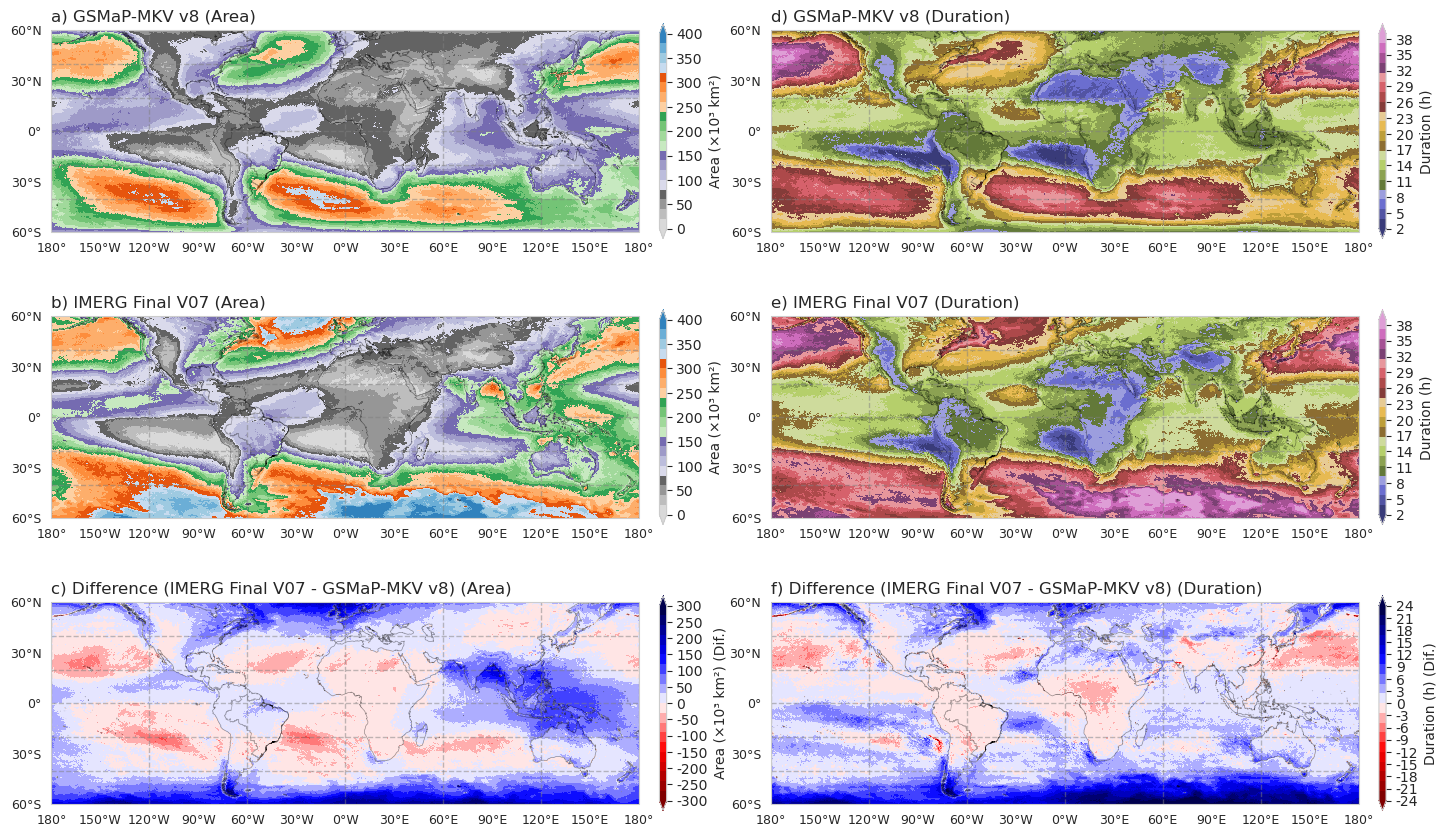

In [17]:
# Figure that shows the frequency of the family
fig, axes = plt.subplots(3, 2, figsize=(18, 26), dpi=100, subplot_kw={'projection': cartopy.crs.PlateCarree()},
                                                          gridspec_kw={'hspace': -0.8, 'wspace': 0.065})
plots.map(gsmap_fam_size, figsize=(12, 18), ax=axes[0,0], title='', ylim=[-60, 60],
          min_val=0, max_val=400000, cmap_num=20, cmap='tab20c_r',
          cbar_extend='both', cbar_fraction=0.1,  cbar_shrink=0.15, cbar_ticks_notation_resumed=True, cbar_label='Area (×10³ km²)',
          cbar_ticks=np.arange(0, 400000 + 50000, 50000))
plots.map(imerg_fam_size, figsize=(12, 18), ax=axes[1,0], title='', ylim=[-60, 60],
            min_val=0, max_val=400000, cmap_num=20, cmap='tab20c_r',
            cbar_extend='both', cbar_fraction=0.1,  cbar_shrink=0.15, cbar_ticks_notation_resumed=True, cbar_label='Area (×10³ km²)',
            cbar_ticks=np.arange(0, 400000 + 50000, 50000))
plots.map(imerg_fam_size - gsmap_fam_size, figsize=(12, 18), ax=axes[2,0], title='',
            cmap_num=20, ylim=[-60, 60], min_val=-300000, max_val=300000, cmap='seismic_r',
            cbar_extend='both', cbar_fraction=0.1,  cbar_shrink=0.15, cbar_ticks_notation_resumed=True,
            cbar_label='Area (×10³ km²) (Dif.)',
            cbar_ticks=np.arange(-300000, 300000 + 50000, 50000))

plots.map(gsmap_fam_duration, figsize=(12, 18), ax=axes[0,1], title='', ylim=[-60, 60],
            min_val=2, max_val=39, cmap_num=20, cmap='tab20b',
            cbar_extend='both', cbar_fraction=0.1,  cbar_shrink=0.15, cbar_label='Duration (h)',
            cbar_ticks=np.arange(2, 39, 3))
plots.map(imerg_fam_duration, figsize=(12, 18), ax=axes[1,1], title='', ylim=[-60, 60],
            min_val=2, max_val=39, cmap_num=20, cmap='tab20b',
            cbar_extend='both', cbar_fraction=0.1,  cbar_shrink=0.15, cbar_label='Duration (h)',
            cbar_ticks=np.arange(2, 39, 3))
plots.map(imerg_fam_duration - gsmap_fam_duration, figsize=(12, 18), ax=axes[2,1], title='',
            cmap_num=20, ylim=[-60, 60], min_val=-24, max_val=24, cmap='seismic_r',
            cbar_extend='both', cbar_fraction=0.1,  cbar_shrink=0.15, cbar_label='Duration (h) (Dif.)',
            cbar_ticks=np.arange(-24, 25 , 3))
axes[0,0].set_title(f"a) {gsmap_name} (Area)", loc='left', y=1)
axes[1,0].set_title(f"b) {imerg_name} (Area)", loc='left', y=1)
axes[2,0].set_title(f"c) Difference ({imerg_name} - {gsmap_name}) (Area)", loc='left', y=1)
axes[0,1].set_title(f"d) {gsmap_name} (Duration)", loc='left', y=1)
axes[1,1].set_title(f"e) {imerg_name} (Duration)", loc='left', y=1)
axes[2,1].set_title(f"f) Difference ({imerg_name} - {gsmap_name}) (Duration)", loc='left', y=1);

##### Figure 5.12 - Frequency distributions of PS area (a) and duration (b), stratified by region: Land, Ocean, Tropics, and Extratropics. Solid lines represent GSMaP, while dashed lines represent IMERG.

In [18]:
# Create GeoDataFrame for Tropical and Extratropical regions
tropics_geom = box(-180, -23.5, 180, 23.5)
extratropics_geom = box(-180, -90, 180, -23.5).union(box(-180, 23.5, 180, 90))
tropics_gdf = gpd.GeoDataFrame({'region': ['Tropics'], 'geometry': [tropics_geom]}, crs='EPSG:4326')
extratropic_gdf = gpd.GeoDataFrame({'region': ['Extratropics'], 'geometry': [extratropics_geom]}, crs='EPSG:4326')

# Create ocean and land masks using cartopy
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m')
ocean_50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m')
land_geom = gpd.GeoDataFrame(geometry=list(land_50m.geometries()), crs='EPSG:4326')
ocean_geom = gpd.GeoDataFrame(geometry=list(ocean_50m.geometries()), crs='EPSG:4326')

In [19]:
gsmap_name_resumed = 'GSMaP'
imerg_name_resumed = 'IMERG'
# Calculate distribution of family size and duration for tropics, extratropics, ocean, and land
regions = {
    'Tropics': tropics_gdf,
    'Extratropics': extratropic_gdf,
    'Ocean': ocean_geom,
    'Land': land_geom
}
products = {
    'gsmap': (gsmap_fam_size, gsmap_fam_duration),
    'imerg': (imerg_fam_size, imerg_fam_duration)
}
data_list = []
for region_name, region_gdf in regions.items():
    for product_name, (fam_size, fam_duration) in products.items():
        # Clip data to the region
        fam_size_clipped = fam_size.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(region_gdf.geometry, region_gdf.crs)
        fam_duration_clipped = fam_duration.rio.write_crs("EPSG:4326").rename({"lat": "y", "lon": "x"}).rio.clip(region_gdf.geometry, region_gdf.crs)
        # Flatten and remove NaN values
        size_values = fam_size_clipped.values.flatten()
        size_values = size_values[~np.isnan(size_values)]
        duration_values = fam_duration_clipped.values.flatten()
        duration_values = duration_values[~np.isnan(duration_values)]
        # Create DataFrames
        size_df = pd.DataFrame({
            'Value': size_values,
            'Type': 'Size (×10³ km²)',
            'Product': gsmap_name_resumed if product_name == 'gsmap' else imerg_name_resumed,
            'Region': region_name
        })
        duration_df = pd.DataFrame({
            'Value': duration_values,
            'Type': 'Duration (h)',
            'Product': gsmap_name_resumed if product_name == 'gsmap' else imerg_name_resumed,
            'Region': region_name
        })
        data_list.append(size_df)
        data_list.append(duration_df)
df_fam = pd.concat(data_list, ignore_index=True)

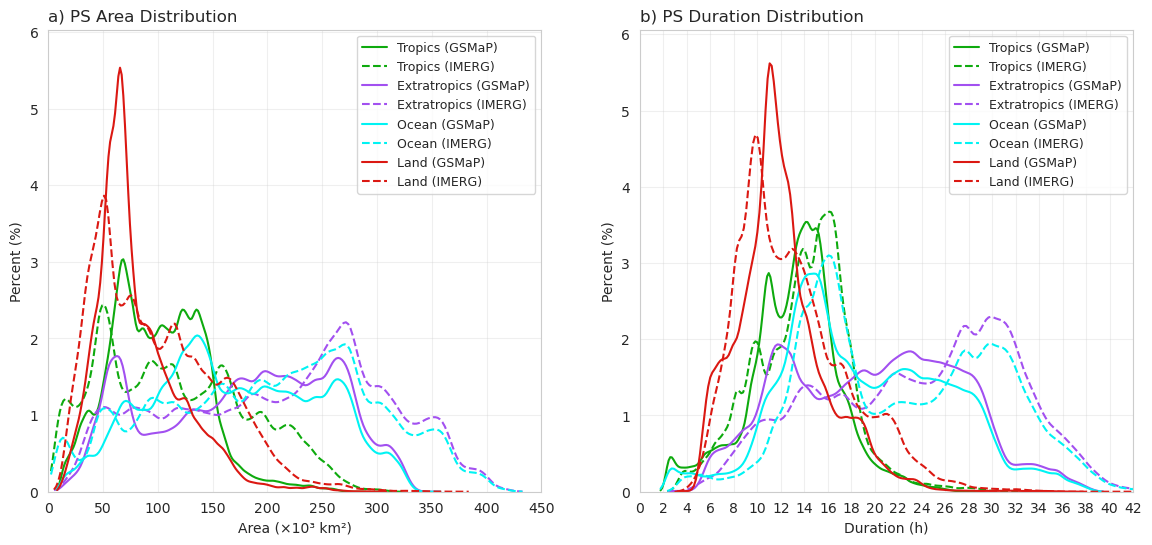

In [21]:
# Create a histogram for family size and duration
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.2})
sns.set_style("whitegrid")

# Define more vibrant colors for regions while maintaining context
region_colors = {
    'Tropics': "#0EAA0E",       # Forest Green (vibrant tropical vegetation)
    'Extratropics': "#A250F0",  # Blue Violet (more vibrant purple for contrast)
    'Ocean': "#00F3F3",         # Royal Blue (deeper, more vibrant ocean blue)
    'Land': "#DB1812"           # Chocolate (warmer, more vibrant brown for land)
}
# Handles para legenda manual
legend_handles = []
# Plot Size histograms
ax_size = axes[0]
for region in regions.keys():
    for product in [gsmap_name_resumed, imerg_name_resumed]:
        region_df = df_fam.loc[
            (df_fam['Region'] == region) &
            (df_fam['Type'] == 'Size (×10³ km²)') &
            (df_fam['Product'] == product)
        ]
        linestyle = '-' if product == gsmap_name_resumed else '--'
        sns.histplot(
            data=region_df, x='Value', bins=100, kde=True, ax=ax_size, 
            color=region_colors[region], stat='percent', element='step', 
            fill=False, alpha=0, kde_kws={'bw_adjust': 1.0}, 
            line_kws={'alpha': 1.0, 'linewidth': 1.5, 'linestyle': linestyle}
        )
        # Criar handle para legenda
        handle = Line2D([0], [0], color=region_colors[region],
                        linestyle=linestyle, linewidth=1.5,
                        label=f'{region} ({product})')
        legend_handles.append(handle)
# Plot Duration histograms
ax_duration = axes[1]
for region in regions.keys():
    for product in [gsmap_name_resumed, imerg_name_resumed]:
        region_df = df_fam.loc[
            (df_fam['Region'] == region) &
            (df_fam['Type'] == 'Duration (h)') &
            (df_fam['Product'] == product)
        ]
        linestyle = '-' if product == gsmap_name_resumed else '--'
        sns.histplot(
            data=region_df, x='Value', bins=100, kde=True, ax=ax_duration, 
            color=region_colors[region], stat='percent', element='step', 
            fill=False, alpha=0, kde_kws={'bw_adjust': 1.0}, 
            line_kws={'alpha': 1.0, 'linewidth': 1.5, 'linestyle': linestyle}
        )
# Set titles and labels
ax_size.set_title('a) PS Area Distribution', fontsize=12, loc='left')
ax_size.set_xlabel('Area (×10³ km²)')
ax_size.set_ylabel('Percent (%)')
ax_size.set_xlim(0, 450000)
ax_size.grid(True, alpha=0.3)
ax_size.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1000:.3f}".rstrip('0').rstrip('.')))
xticks = np.arange(0, 43, 2)
ax_duration.set_xticks(xticks)
ax_duration.set_title('b) PS Duration Distribution', fontsize=12, loc='left')
ax_duration.set_xlabel('Duration (h)')
ax_duration.set_ylabel('Percent (%)')
ax_duration.set_xlim(0, 42)
ax_duration.grid(True, alpha=0.3)
ax_size.legend(handles=legend_handles, loc='upper right', fontsize=9)
ax_duration.legend(handles=legend_handles, loc='upper right', fontsize=9)
plt.show()

##### Figure 5.13 - Distribution of PS area over their life cycle, stratified by surface type Ocean (a and b) and Land (c).

In [4]:
def evolutionByLifetime(con, table, save_path='queries/evolution/', columns=['lifetime', 'size','region_type']):
    pathlib.Path(save_path).mkdir(parents=True, exist_ok=True)
    file_path = pathlib.Path(save_path) / f"{table}_evolution_by_lifetime.parquet"
    delta = {'gsmap_v8': 1, 'imerg_v7': 0.5}.get(table, 0)
    if file_path.exists():
        print(f"File {file_path} already exists. Skipping query execution.")
        return pd.read_parquet(file_path, columns=columns)
    query = f"""
        WITH collect_data AS (
        SELECT
            timestamp,
            lifetime,
            size,
            latitude,
            region,
            genesis,
            max as max_precipitation,
            mean as mean_precipitation,
            inside_clusters,
            ST_Centroid(ST_GeomFromText(geometry)) AS centroid
        FROM {table}
        )
        SELECT
            timestamp,
            (lifetime / 60) - {delta} AS lifetime,
            size / (0.1 * 0.1) AS size,
            CASE
                WHEN latitude LIKE '%Tropical%' THEN 'Tropical'
                ELSE 'Extratropical'
            END AS latitude,
            CASE
                WHEN region ILIKE '%Ocean%' OR region ILIKE '%Sea%' THEN 'Ocean'
                ELSE 'Land'
            END AS region_type,
            region,
            genesis,
            CASE
                WHEN ((EXTRACT(hour FROM timestamp) + CAST(ST_X(centroid) / 15 AS INT)) % 24) BETWEEN 6 AND 17
                THEN 'Day'
                ELSE 'Night'
            END AS day_night,
            ST_AsText(centroid) AS centroid_wkt,
            max_precipitation,
            mean_precipitation,
            inside_clusters
        FROM collect_data
        """
    con.execute(f"""
            COPY ({query})
            TO '{file_path}'
            (FORMAT 'parquet', OVERWRITE)
            """)
    print(f"Evolution data saved to {file_path}")

In [5]:
gsmap_size_df = evolutionByLifetime(con, 'gsmap_tracking', columns=['lifetime', 'size','region_type'])
imerg_size_df = evolutionByLifetime(con, 'imerg_tracking', columns=['lifetime', 'size','region_type'])

File queries/evolution/gsmap_tracking_evolution_by_lifetime.parquet already exists. Skipping query execution.
File queries/evolution/imerg_tracking_evolution_by_lifetime.parquet already exists. Skipping query execution.


In [50]:
def plot_histograms(gsmap_size_df, imerg_size_df, 
                    title_1='GSMaP', title_2='IMERG', 
                    var_name='Area', variable='size',
                    freq_elevation=1e4, ax=None,
                    xlim=(0, 72), ylim=(0, 56), scale_str = 'km²', 
                    bounds = [0.05, 0.1, 0.2, 0.4, 0.6, 1.0, 1.5, 2.0, 5, 10, 50, 80]):
    elev_str = {1e4: '×10⁴', 1e3: '×10³', 1e2: '×10²'}.get(freq_elevation, '')
    # Extract x and y values
    gsmap_x = gsmap_size_df['lifetime'].values
    gsmap_y = gsmap_size_df[variable].values / freq_elevation
    imerg_x = imerg_size_df['lifetime'].values
    imerg_y = imerg_size_df[variable].values / freq_elevation
    # Define bin edges
    gsmap_bins_x = np.arange(xlim[0], xlim[1] + 1, 1)
    gsmap_bins_y = np.arange(ylim[0], ylim[1] + 1, 1)
    imerg_bins_x = np.arange(xlim[0], xlim[1] + 1, .5)
    imerg_bins_y = np.arange(ylim[0], ylim[1] + 1, .5)
    # Compute 2D histogram
    gsmap_H_counts, gsmap_xedges, gsmap_yedges = np.histogram2d(gsmap_x, gsmap_y, bins=[gsmap_bins_x, gsmap_bins_y], density=False)
    imerg_H_counts, imerg_xedges, imerg_yedges = np.histogram2d(imerg_x, imerg_y, bins=[imerg_bins_x, imerg_bins_y], density=False)
    gsmap_H_scaled = gsmap_H_counts / freq_elevation
    imerg_H_scaled = imerg_H_counts / freq_elevation
    cmap = plt.get_cmap('turbo')
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)
    # Mask values below minimum threshold
    gsmap_H_masked = np.ma.masked_where(gsmap_H_scaled < bounds[0], gsmap_H_scaled)
    imerg_H_masked = np.ma.masked_where(imerg_H_scaled < bounds[0], imerg_H_scaled)
    # Garantir que ax seja uma tupla/lista de dois subplots
    if ax is None:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100, gridspec_kw={'wspace': 0.2})
    else:
        if isinstance(ax, np.ndarray):
            axes = ax
        elif isinstance(ax, list) or isinstance(ax, tuple):
            axes = ax
        else:
            raise ValueError("The 'ax' parameter must be None or a list/array of two Axes objects.")
        fig = axes[0].figure
    # Plot GSMaP
    pcm1 = axes[0].pcolormesh(gsmap_xedges, gsmap_yedges, gsmap_H_masked.T, cmap=cmap, norm=norm, shading='auto')
    axes[0].set_title(title_1, fontsize=12, loc='left')
    axes[0].set_xlabel('Lifetime (h)')
    axes[0].set_ylabel(f'{var_name} {elev_str} {scale_str}', fontsize=12)
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)
    axes[0].grid(True, alpha=0.3)
    axes[0].xaxis.set_major_locator(MaxNLocator(nbins=16))
    axes[0].yaxis.set_major_locator(MaxNLocator(nbins=16))

    # Plot IMERG
    pcm2 = axes[1].pcolormesh(imerg_xedges, imerg_yedges, imerg_H_masked.T, cmap=cmap, norm=norm, shading='auto')
    axes[1].set_title(title_2, fontsize=12, loc='left')
    axes[1].set_xlabel('Lifetime (h)', fontsize=10)
    axes[1].set_ylabel(f'{var_name} {elev_str} {scale_str}', fontsize=12)
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)
    axes[1].grid(True, alpha=0.3)
    # xticks = np.arange(xlim[0], xlim[1]+1, 4)
    yticks = np.arange(ylim[0], ylim[1]+1, 4)
    for a in axes:
    #     a.set_xticks(xticks)
        a.set_yticks(yticks)
    axes[0].set_xticks(np.arange(xlim[0] + 1, xlim[1]+1, 5))
    axes[1].set_xticks(np.arange(xlim[0] + 0.5, xlim[1]+1, 5.5))
    # for ticks in axes[1], remove .0 from x-ticks, set only if have .5
    def format_xtick(x, pos):
        if x.is_integer():
            return f"{int(x)}"
        else:
            return f"{x:.1f}".rstrip('0').rstrip('.')
    axes[1].xaxis.set_major_formatter(FuncFormatter(format_xtick))
    cbar = fig.colorbar(pcm2, ax=axes, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label(f"Frequency {elev_str}", fontsize=10)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}".rstrip('0').rstrip('.')))
    cbar.set_ticks(bounds)

In [7]:
gsmap_size_ocean_df = gsmap_size_df[gsmap_size_df['region_type'] == 'Ocean']
imerg_size_ocean_df = imerg_size_df[imerg_size_df['region_type'] == 'Ocean']
gsmap_size_land_df = gsmap_size_df[gsmap_size_df['region_type'] == 'Land']
imerg_size_land_df = imerg_size_df[imerg_size_df['region_type'] == 'Land']

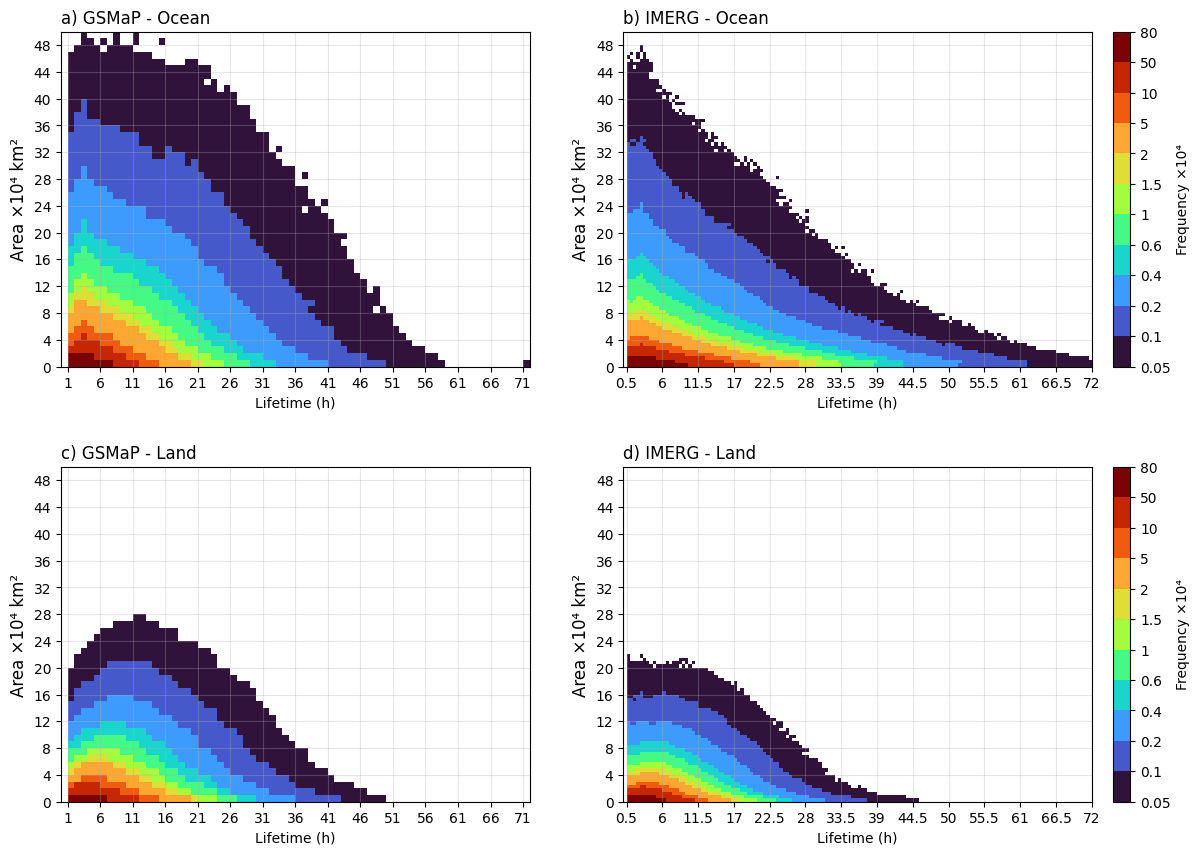

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100, gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
plot_histograms(gsmap_size_ocean_df, imerg_size_ocean_df, "a) GSMaP - Ocean", "b) IMERG - Ocean", ax=axes[0], ylim=(0, 50))
plot_histograms(gsmap_size_land_df, imerg_size_land_df, "c) GSMaP - Land", "d) IMERG - Land", ax=axes[1], ylim=(0, 50))

In [4]:
### SELECT STRATIFIED BY REGION TYPE (TROPICAL AND EXTRATROPICAL)
from filters import stratified_far_dataset

In [ ]:
gsmap_stratified_far = stratified_far_dataset(con, "gsmap_tracking")
imerg_stratified_far = stratified_far_dataset(con, "imerg_tracking")

In [73]:
query = """
PRAGMA enable_object_cache = true;

WITH gsmap AS (
  SELECT DISTINCT uid, duration_class
  FROM read_parquet(
    'queries/stratified_far_dataset/gsmap_tracking_stratified_far.parquet',
    union_by_name := true
  )
),
gsmap_last AS (
  SELECT
    uid,
    arg_max(duration, timestamp) AS duration
  FROM gsmap_tracking
  WHERE uid IN (SELECT uid FROM gsmap)
  GROUP BY uid
)
SELECT
  i.duration_class,
  LIST(g.uid ORDER BY g.uid)       AS uids,
  LIST(g.duration ORDER BY g.uid)  AS durations
FROM gsmap i
JOIN gsmap_last g USING (uid)
GROUP BY i.duration_class
ORDER BY i.duration_class;
"""

gsmap_duration_by_class = con.execute(query).df()
imerg_duration_by_class = con.execute(query.replace("gsmap", "imerg")).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [77]:
gsmap_duration_by_class['durations'] = (gsmap_duration_by_class['durations']) / 60
imerg_duration_by_class['durations'] = (imerg_duration_by_class['durations'] + 60) / 60

In [78]:
# Print descriptive statistics for gsmap_duration_by_class, based on column 'durations'
gsmap_long = gsmap_duration_by_class['durations'].iloc[0]
gsmap_medium = gsmap_duration_by_class['durations'].iloc[1]
gsmap_short = gsmap_duration_by_class['durations'].iloc[2]

imerg_long = imerg_duration_by_class['durations'].iloc[0]
imerg_medium = imerg_duration_by_class['durations'].iloc[1]
imerg_short = imerg_duration_by_class['durations'].iloc[2]
# Add descriptive statistics into a single dataframe
gsmap_descr_stats = pd.DataFrame({
    'Class': ['Long', 'Medium', 'Short'],
    'Count': [len(gsmap_long), len(gsmap_medium), len(gsmap_short)],
    'Mean (hours)': [np.mean(gsmap_long), np.mean(gsmap_medium), np.mean(gsmap_short)],
    'Median (hours)': [np.median(gsmap_long), np.median(gsmap_medium), np.median(gsmap_short)],
    'Std Dev (hours)': [np.std(gsmap_long), np.std(gsmap_medium), np.std(gsmap_short)],
    'Min (hours)': [np.min(gsmap_long), np.min(gsmap_medium), np.min(gsmap_short)],
    'Max (hours)': [np.max(gsmap_long), np.max(gsmap_medium),
                     np.max(gsmap_short)],
    '25th Percentile (hours)': [np.percentile(gsmap_long, 25), np.percentile(gsmap_medium, 25), np.percentile(gsmap_short, 25)],
    '75th Percentile (hours)': [np.percentile(gsmap_long, 75), np.percentile(gsmap_medium, 75), np.percentile(gsmap_short, 75)]
})
imerg_descr_stats = pd.DataFrame({
    'Class': ['Long', 'Medium', 'Short'],
    'Count': [len(imerg_long), len(imerg_medium), len(imerg_short)],
    'Mean (hours)': [np.mean(imerg_long), np.mean(imerg_medium), np.mean(imerg_short)],
    'Median (hours)': [np.median(imerg_long), np.median(imerg_medium), np.median(imerg_short)],
    'Std Dev (hours)': [np.std(imerg_long), np.std(imerg_medium), np.std(imerg_short)],
    'Min (hours)': [np.min(imerg_long), np.min(imerg_medium), np.min(imerg_short)],
    'Max (hours)': [np.max(imerg_long), np.max(imerg_medium),
                     np.max(imerg_short)],
    '25th Percentile (hours)': [np.percentile(imerg_long, 25), np.percentile(imerg_medium, 25), np.percentile(imerg_short, 25)],
    '75th Percentile (hours)': [np.percentile(imerg_long, 75), np.percentile(imerg_medium, 75), np.percentile(imerg_short, 75)]
})

In [ ]:
gsmap_short = con.execute(f"SELECT * FROM 'queries/haversine_by_class/gsmap_Short.parquet'").df()
gsmap_medium = con.execute(f"SELECT * FROM 'queries/haversine_by_class/gsmap_Medium.parquet'").df()
gsmap_long = con.execute(f"SELECT * FROM 'queries/haversine_by_class/gsmap_Long.parquet'").df()

imerg_short = con.execute(f"SELECT * FROM 'queries/haversine_by_class/imerg_Short.parquet'").df()
imerg_medium = con.execute(f"SELECT * FROM 'queries/haversine_by_class/imerg_Medium.parquet'").df()
imerg_long = con.execute(f"SELECT * FROM 'queries/haversine_by_class/imerg_Long.parquet'").df()

In [80]:
gsmap_short['dataset'] = 'GSMaP'
gsmap_medium['dataset'] = 'GSMaP'
gsmap_long['dataset'] = 'GSMaP'
imerg_short['dataset'] = 'IMERG'
imerg_medium['dataset'] = 'IMERG'
imerg_long['dataset'] = 'IMERG'

gsmap_short['class'] = 'Short'
gsmap_medium['class'] = 'Medium'
gsmap_long['class'] = 'Long'
imerg_short['class'] = 'Short'
imerg_medium['class'] = 'Medium'
imerg_long['class'] = 'Long'

# Combina por produto
gsmap_all = pd.concat([gsmap_short, gsmap_medium, gsmap_long])
imerg_all = pd.concat([imerg_short, imerg_medium, imerg_long])

In [81]:
gsmap_descr_stats

,Class,Count,Mean (hours),Median (hours),Std Dev (hours),Min (hours),Max (hours),25th Percentile (hours),75th Percentile (hours)
0,Long,663113,21.124992,16.0,16.468555,12.0,562.0,13.0,22.0
1,Medium,2207325,7.531263,7.0,1.557170,6.0,11.0,6.0,9.0
2,Short,7569350,3.625548,3.0,0.753883,3.0,5.0,3.0,4.0


In [82]:
imerg_descr_stats

,Class,Count,Mean (hours),Median (hours),Std Dev (hours),Min (hours),Max (hours),25th Percentile (hours),75th Percentile (hours)
0,Long,1415535,19.891294,15.5,15.562762,11.5,605.0,13.0,21.0
1,Medium,4639711,7.596743,7.0,1.445323,6.0,11.0,6.5,8.5
2,Short,16614957,3.838161,3.5,0.800228,3.0,5.5,3.0,4.5


In [83]:
gsmap_all.groupby('class')['start_end_haversine_km'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
Long,663113.0,540.692024,695.166252,0.0,196.314229,346.766553,611.373585,14078.398301
Medium,2207325.0,156.009702,130.679128,0.0,74.613233,124.983860,198.262262,5183.170523
Short,7569350.0,66.970326,63.409653,0.0,31.033227,51.627230,83.233023,4803.349874


In [84]:
imerg_all.groupby('class')['start_end_haversine_km'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
Long,1415535.0,492.047023,644.832946,1.580175e-12,186.539861,332.887059,568.703641,15086.605656
Medium,4639711.0,158.236531,129.448973,0.000000e+00,69.619939,127.809308,209.489411,5435.479565
Short,16614957.0,71.500387,63.047951,0.000000e+00,29.501830,56.340141,94.900732,5288.524578


In [85]:
imerg_duration_by_class

,duration_class,uids,durations
0,Long,"[9.0, 19.0, 28.0, 92.0, 93.0, 101.0, 111.0, 11...","[11.5, 27.5, 12.0, 13.0, 22.0, 14.5, 105.0, 28..."
1,Medium,"[8.0, 16.0, 57.0, 63.0, 72.0, 79.0, 143.0, 174...","[6.0, 8.5, 6.5, 6.0, 6.0, 6.0, 9.0, 9.0, 6.0, ..."
2,Short,"[1.0, 15.0, 26.0, 34.0, 36.0, 37.0, 38.0, 45.0...","[4.0, 5.5, 3.0, 5.5, 3.5, 3.5, 3.0, 3.5, 3.0, ..."


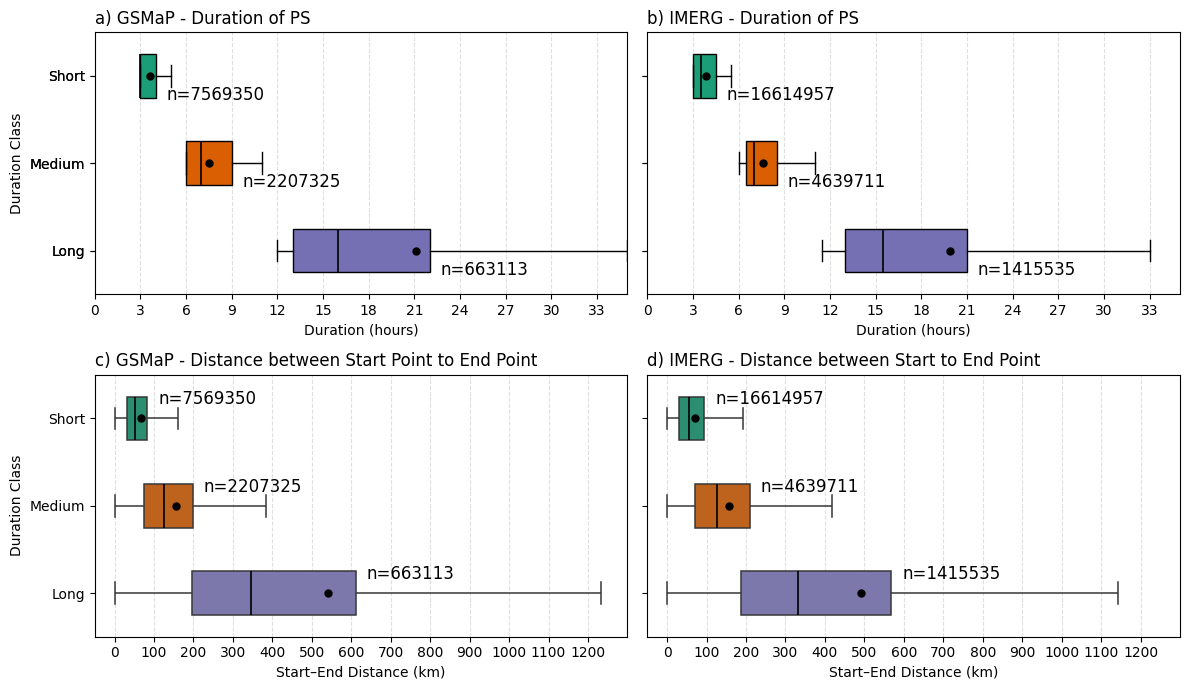

In [88]:
palette = {'Short': '#1b9e77', 'Medium': '#d95f02', 'Long': '#7570b3'}
meanprops = {"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black", "markersize": 5}
medianprops = {"color": "black", "linewidth": 1.2}
order = ['Short', 'Medium', 'Long']

xticks_dist = np.arange(0, 1300, 100)
xlim_dist = (-50, 1300)
xticks_dur = np.arange(0, 35, 3)
xlim_dur = (0, 35)

def get_box_data(df):
    data = [np.asarray(row['durations'], float) for _, row in df.iterrows()]
    labels = df['duration_class'].tolist()
    return data, labels

def annotate_above_right_duration(ax, data, y0=1, dx_frac=0.02, dy=0.25, fmt="n={n}", fontsize=12):
    xmin, xmax = ax.get_xlim(); dx = (xmax - xmin) * dx_frac
    for i, arr in enumerate(data, start=y0):
        if len(arr) == 0: continue
        q3 = np.nanpercentile(arr, 75)
        x = min(q3 + dx, xmax - dx)
        ax.text(x, i - dy, fmt.format(n=len(arr)), ha='left', va='center', fontsize=fontsize, clip_on=False)

def annotate_above_right_seaborn(ax, series_by_class, order, dx_frac=0.02, dy=0.25, fmt="n={n}", fontsize=12):
    xmin, xmax = ax.get_xlim(); dx = (xmax - xmin) * dx_frac
    for i, cls in enumerate(order):
        s = series_by_class.get(cls, pd.Series([], dtype=float))
        if s.size == 0: continue
        q3 = np.nanpercentile(s, 75)
        x = min(q3 + dx, xmax - dx)
        ax.text(x, i - dy, fmt.format(n=int(s.size)), ha='left', va='center', fontsize=fontsize, clip_on=False)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7), sharey='row')

# (a) GSMaP – Duração
gsmap_data, gsmap_labels = get_box_data(gsmap_duration_by_class)
bplot1 = axes[0, 0].boxplot(gsmap_data, vert=False, labels=gsmap_labels, patch_artist=True,
                            showmeans=True, meanprops=meanprops, medianprops=medianprops,
                            widths=0.5, showfliers=False)
for patch, cls in zip(bplot1['boxes'], gsmap_labels):
    patch.set_facecolor(palette[cls])
axes[0, 0].set_title('a) GSMaP - Duration of PS', loc='left', fontsize=12)
axes[0, 0].set_xlabel('Duration (hours)'); axes[0, 0].set_ylabel('Duration Class')
axes[0, 0].set_xticks(xticks_dur); axes[0, 0].set_xlim(xlim_dur)
axes[0, 0].grid(True, axis='x', linestyle='--', alpha=0.4); axes[0, 0].set_axisbelow(True)
annotate_above_right_duration(axes[0, 0], gsmap_data, dy=0.22)

# (b) IMERG – Duração
imerg_data, imerg_labels = get_box_data(imerg_duration_by_class)
bplot2 = axes[0, 1].boxplot(imerg_data, vert=False, labels=imerg_labels, patch_artist=True,
                            showmeans=True, meanprops=meanprops, medianprops=medianprops,
                            widths=0.5, showfliers=False)
for patch, cls in zip(bplot2['boxes'], imerg_labels):
    patch.set_facecolor(palette[cls])
axes[0, 1].set_title('b) IMERG - Duration of PS', loc='left', fontsize=12)
axes[0, 1].set_xlabel('Duration (hours)'); axes[0, 1].set_ylabel('')
axes[0, 1].set_xticks(xticks_dur); axes[0, 1].set_xlim(xlim_dur)
axes[0, 1].grid(True, axis='x', linestyle='--', alpha=0.4); axes[0, 1].set_axisbelow(True)
annotate_above_right_duration(axes[0, 1], imerg_data, dy=0.22)

# (c) GSMaP – Distância
sns.boxplot(data=gsmap_all, x='start_end_haversine_km', y='class', order=order,
            orient='h', palette=palette, showfliers=False, showmeans=True,
            meanprops=meanprops, medianprops=medianprops, linewidth=1.1, width=0.5, ax=axes[1, 0])
axes[1, 0].set_title('c) GSMaP - Distance between Start Point to End Point', loc='left', fontsize=12)
axes[1, 0].set_xlabel('Start–End Distance (km)'); axes[1, 0].set_ylabel('Duration Class')
axes[1, 0].set_xticks(xticks_dist); axes[1, 0].set_xlim(xlim_dist)
axes[1, 0].grid(True, axis='x', linestyle='--', alpha=0.4); axes[1, 0].set_axisbelow(True)
gsmap_series = {cls: gsmap_all.loc[gsmap_all['class'] == cls, 'start_end_haversine_km'].dropna().values for cls in order}
gsmap_series = {k: pd.Series(v) for k, v in gsmap_series.items()}
annotate_above_right_seaborn(axes[1, 0], gsmap_series, order, dy=0.22)

# (d) IMERG – Distância
sns.boxplot(data=imerg_all, x='start_end_haversine_km', y='class', order=order,
            orient='h', palette=palette, showfliers=False, showmeans=True,
            meanprops=meanprops, medianprops=medianprops, linewidth=1.1, width=0.5, ax=axes[1, 1])
axes[1, 1].set_title('d) IMERG - Distance between Start to End Point', loc='left', fontsize=12)
axes[1, 1].set_xlabel('Start–End Distance (km)'); axes[1, 1].set_ylabel('')
axes[1, 1].set_xticks(xticks_dist); axes[1, 1].set_xlim(xlim_dist)
axes[1, 1].grid(True, axis='x', linestyle='--', alpha=0.4); axes[1, 1].set_axisbelow(True)
imerg_series = {cls: imerg_all.loc[imerg_all['class'] == cls, 'start_end_haversine_km'].dropna().values for cls in order}
imerg_series = {k: pd.Series(v) for k, v in imerg_series.items()}
annotate_above_right_seaborn(axes[1, 1], imerg_series, order, dy=0.22)

plt.tight_layout()
plt.show()

In [ ]:
gsmap_ds_1200_500 = loadSpatialTracking("/prj/cptec/helvecio.leal/tracks/gsmap/spatial_720_0/")
imerg_ds_1200_500 = loadSpatialTracking("/prj/cptec/helvecio.leal/tracks/imerg/spatial_720_0/")

Loading spatial tracking data from: /prj/cptec/helvecio.leal/tracks/gsmap/spatial_720_0/
Loading spatial tracking data from: /prj/cptec/helvecio.leal/tracks/imerg/spatial_720_0/


In [7]:
gsmap_initiation = gsmap_ds_1200_500['fam-initiation'].sum(dim='time', skipna=True).compute()
gsmap_dissipation = gsmap_ds_1200_500['fam-dissipation'].sum(dim='time', skipna=True).compute()

imerg_initiation = imerg_ds_1200_500['fam-initiation'].sum(dim='time', skipna=True).compute()
imerg_dissipation = imerg_ds_1200_500['fam-dissipation'].sum(dim='time', skipna=True).compute()

Text(0.0, 1, 'b) IMERG - Long Duration PSs (≥ 12h) (Dissipation - Initiation)')

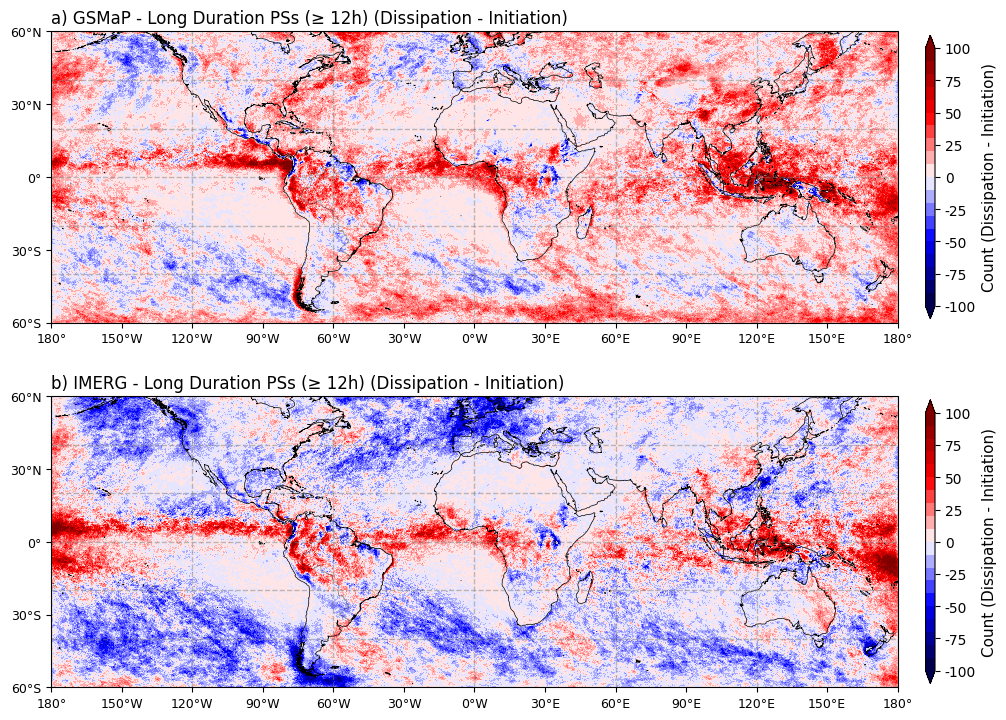

: 

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=100, subplot_kw={'projection': cartopy.crs.PlateCarree()}, gridspec_kw={'hspace': -0.1, 'wspace': 0.13})

diff1 = gsmap_dissipation - gsmap_initiation
plots.map(diff1, figsize=(12, 6), title=f"", ylim=[-60, 60], ax=axes[0],
          cmap_num=20, cmap='seismic', min_val=-100, max_val=100,
          cbar_extend='both', cbar_fraction=0.06,  cbar_shrink=0.7,
          cbar_label='Count (Dissipation - Initiation)');

diff2 = imerg_dissipation - imerg_initiation
plots.map(diff2, figsize=(12, 6), title=f"", ylim=[-60, 60], ax=axes[1],
          cmap_num=20, cmap='seismic', min_val=-100, max_val=100,
          cbar_extend='both', cbar_fraction=0.06,  cbar_shrink=0.7,
          cbar_label='Count (Dissipation - Initiation)')
axes[0].set_title(f"a) GSMaP - Long Duration PSs (≥ 12h) (Dissipation - Initiation)", loc='left', y=1)
axes[1].set_title(f"b) IMERG - Long Duration PSs (≥ 12h) (Dissipation - Initiation)", loc='left', y=1);